<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/main/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
#%%capture
#!pip install requests umap nltk gensim

In [2]:
import os
import requests
from pathlib import Path
import re
import json
from typing import OrderedDict
import copy

import numpy as np
import pandas as pd

import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt

from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.downloader as gloader

import torch

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import evaluate

# Class definition

In [3]:
class SexismDetector:
    def __init__(self):

        URL_PATTERN_STR = r"""(?i)((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info
                      |int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|
                      bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|
                      cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|
                      gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|
                      la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|
                      nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|
                      sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|
                      uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]
                      *?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])|(?:(?<!@)
                      [a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name
                      |post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn
                      |bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg
                      |eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id
                      |ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|
                      md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|
                      ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|
                      sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|
                      za|zm|zw)\b/?(?!@)))"""
        self.URL_PATTERN = re.compile(URL_PATTERN_STR, re.IGNORECASE)
        self.HASHTAG_PATTERN = re.compile(r'#\w*')
        self.MENTION_PATTERN = re.compile(r'@\w*')
        self.EMOJIS_PATTERN = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
        self.SPECIAL_CHARACTERS_PATTERN = re.compile(r'&lt;/?[a-z]+&gt;')
        self.AND_PATTERN = re.compile(r'&amp;')
        self.WORD_PATTERN = re.compile(r'[^a-zA-Z\s]')
        self.SEED = 1337
        self.DATA_FOLDER = Path('data')
        self.MODEL_FOLDER = Path('models')
        self.columns_to_maintain = ['id_EXIST', 'lang', 'tweet', 'hard_label_task1']
        self.UNK_TOKEN = '[UNK]'
        self.PAD_TOKEN = '[PAD]'

    def download_corpus(self, url: str, filename: str) -> None:
        """
        Downloads a text corpus from a given URL and saves it to a specified filename within the data folder.

        Args:
            url (str): The URL from which to download the corpus.
            filename (str): The name of the file to save the downloaded corpus.

        Raises:
            requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

        Side Effects:
            Creates the data folder if it does not exist.
            Writes the downloaded corpus to the specified file.
        """
        if not self.DATA_FOLDER.exists():
            self.DATA_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.DATA_FOLDER}.")

        response = requests.get(url)
        response.raise_for_status()
        with open(self.DATA_FOLDER / filename, 'w', encoding='utf-8') as f:
            f.write(response.text)

    def load_corpus(self, filename: str, *args, **kwargs) -> pd.DataFrame:
        """
        Load a corpus from a JSON file.

        Parameters:
        filename (str): The name of the JSON file to load.
        *args: Variable length argument list to pass to pandas read_json.
        **kwargs: Arbitrary keyword arguments to pass to pandas read_json.

        Returns:
        DataFrame: A pandas DataFrame containing the loaded corpus.
        """
        return pd.read_json(self.DATA_FOLDER / filename, *args, **kwargs)

    @staticmethod
    def majority_voting(votes: list[str]) -> str:
        """
        Determines the majority vote from a list of votes.
        Args:
            votes (list[str]): A list of votes, where each vote is either "YES" or "NO".
        Returns:
            str: The result of the majority vote. Returns "YES" if there are more "YES" votes,
                "NO" if there are more "NO" votes, and "NEUTRAL" in case of a tie.
        """
        total_num_votes = len(votes)
        yes_votes = votes.count("YES")
        no_votes = total_num_votes - yes_votes

        if yes_votes > no_votes:
            return "YES"
        elif no_votes > yes_votes:
            return "NO"
        else:
            return "NEUTRAL" # This will be the case when there is a tie (removed later)

    def preprocess_text(self, text: str) -> str:
        """
        Preprocesses the input text by removing or replacing specific patterns.

        Args:
            text (str): The input text to be preprocessed.

        Returns:
            str: The preprocessed text with URLs, mentions, hashtags, emojis, 
                 special characters removed, 'and' replaced, and extra spaces trimmed.
        """
        text = self.URL_PATTERN.sub('', text)
        text = self.MENTION_PATTERN.sub('', text)
        text = self.HASHTAG_PATTERN.sub('', text)
        text = self.EMOJIS_PATTERN.sub('', text)
        text = self.SPECIAL_CHARACTERS_PATTERN.sub('', text)
        text = self.AND_PATTERN.sub('and', text)
        text = text.strip()
        text = self.WORD_PATTERN.sub(' ', text)
        text = text.strip()
        return text

    def lemmatize_text(self, text: str) -> str:
        """
        Lemmatizes the input text using the WordNet lemmatizer.

        This method attempts to lemmatize each word in the input text. If the WordNet
        data is not available, it will download the necessary data and retry.

        Args:
            text (str): The input text to be lemmatized.

        Returns:
            str: The lemmatized text.
        """
        lemmatizer = WordNetLemmatizer()
        downloaded = False
        while not downloaded:
            try:
                lemmatizer.lemmatize(text)
                downloaded = True
            except LookupError:
                print("Downloading WordNet...")
                nltk.download('wordnet')
        return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    @staticmethod
    def text_diff(original_text: str, preprocessed_text: str, random: bool = True) -> None:
        """
        Displays a comparison between an original tweet and its preprocessed version.
        Args:
            original_text (str): The original text data containing tweets.
            preprocessed_text (str): The preprocessed text data containing tweets.
            random (bool, optional): If True, a random tweet is selected for comparison. 
                                     If False, the first tweet is selected. Defaults to True.
        Returns:
            None
        """
        if random:
            idx = np.random.randint(0, preprocessed_text.shape[0])
        else:
            idx = 0

        print(f"Original tweet:\n{original_text['tweet'].iloc[idx]}")
        print(f"Processed tweet:\n{preprocessed_text['tweet'].iloc[idx]}")

    def load_glove(self, model_name: str = 'glove-wiki-gigaword', embedding_dim: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
        """
        Loads the GloVe model with the specified name and embedding dimension.
        Args:
            model_name (str): The name of the GloVe model to load. Default is 'glove-wiki-gigaword'.
            embedding_dim (int): The dimension of the word embeddings. Default is 50.
        Returns:
            gensim.models.keyedvectors.KeyedVectors: The loaded GloVe model.
        Raises:
            Exception: If there is an error in downloading or loading the model.
        Notes:
            - If the model folder does not exist, it will be created.
            - If the model is not already downloaded, it will be downloaded and saved to the specified path.
            - If the model is already downloaded, it will be loaded from the specified path.
        """
        self.EMBEDDING_DIM = embedding_dim

        if not self.MODEL_FOLDER.exists():
            self.MODEL_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.MODEL_FOLDER}.")
        
        model_path = self.MODEL_FOLDER / f"{model_name}-{embedding_dim}"
        if not model_path.exists():
            print(f"Downloading {model_name} model...")
            glove_model = gloader.load(f"{model_name}-{embedding_dim}")
            print(f"Model downloaded! Saving to {model_path}")
            glove_model.save(str(model_path))
            print(f"Model saved to {self.MODEL_FOLDER / f'{model_name}-{embedding_dim}'}")
        else:
            glove_model = gensim.models.keyedvectors.KeyedVectors.load(str(model_path))
        return glove_model

    def get_vocab(self, data: pd.DataFrame) -> tuple[OrderedDict, OrderedDict]:
        """
        Generates vocabulary mappings from a given dataset.
        Args:
            data (pd.DataFrame): A pandas DataFrame containing the dataset with a column 'tweet'.
            word_listing (list, optional): A list of words to include in the vocabulary. If None, the vocabulary
                                           will be built from the dataset. Defaults to None.
        Returns:
            tuple[OrderedDict, OrderedDict]: A tuple containing two OrderedDicts:
                - idx_to_word: Mapping from index to word.
                - word_to_idx: Mapping from word to index.
        """
        idx_to_word = OrderedDict()
        word_to_idx = OrderedDict()

        curr_idx = 0
        for sentence in data.tweet.values:
            tokens = sentence.split()
            for token in tokens:
                if token not in word_to_idx:
                    word_to_idx[token] = curr_idx
                    idx_to_word[curr_idx] = token
                    curr_idx += 1

        word_listing = list(idx_to_word.values())
        return idx_to_word, word_to_idx, word_listing

    def co_occurrence_count(self, df: pd.DataFrame, idx_to_word, word_to_idx, window_size: int = 10) -> np.ndarray:

        vocab_size = len(idx_to_word)
        co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
        
        for sentence in tqdm(df.tweet.values):
            tokens = sentence.split()
            for pos, token in enumerate(tokens):
                start = max(0, pos - window_size)
                end = min(pos + window_size + 1, len(tokens))

                first_word_index = word_to_idx[token]

                for pos2 in range(start, end):
                    if pos2 != pos:
                        second_token = tokens[pos2]
                        second_word_index = word_to_idx[second_token]
                        co_occurrence_matrix[first_word_index, second_word_index] += 1

        return co_occurrence_matrix

    def co_occurrence_dataframe(self, co_occurrence_matrix: np.ndarray, idx_to_word: OrderedDict) -> pd.DataFrame:
        """
        Converts a co-occurrence matrix into a pandas DataFrame with word indices as row and column labels.
        Args:
            co_occurrence_matrix (np.ndarray): A co-occurrence matrix with word indices as row and column indices.
            idx_to_word (OrderedDict): A mapping from word index to word.
        Returns:
            pd.DataFrame: A pandas DataFrame with word indices as row and column labels.
        """
        return pd.DataFrame(co_occurrence_matrix, index=idx_to_word.values(), columns=idx_to_word.values())

    def get_augmented_vocab(self, emb_model: gensim.models.keyedvectors.KeyedVectors, train_words: list, co_occurrence_df: pd.DataFrame, save: bool = False) -> gensim.models.keyedvectors.KeyedVectors:
        """
        Augments the given embedding model with new tokens from the training words list. If a token is not found in the 
        embedding model, a random vector is generated for it. Optionally saves the updated vocabulary to a JSON file.
        Args:
            emb_model (gensim.models.keyedvectors.KeyedVectors): The embedding model to augment.
            train_words (list): A list of words to add to the embedding model.
            co_occurrence_df (pd.DataFrame): A DataFrame containing co-occurrence data for the training words.
            save (bool, optional): If True, saves the updated vocabulary to a JSON file. Defaults to False.
        Returns:
            gensim.models.keyedvectors.KeyedVectors: The augmented embedding model.
        """
        new_tokens = []
        new_vectors = []
        for token in train_words:
            try:
                embedding_vec = emb_model.get_vector(token)
            except KeyError:
                try:
                    # Handle missing token in embedding model
                    top_5_most_frequent = co_occurrence_df.loc[token].sort_values(ascending=False).index.tolist()[:5]

                    # Filter words that are in the embedding model
                    valid_words = [word for word in top_5_most_frequent if word in emb_model.key_to_index]

                    if valid_words:
                        # Calculate the average vector for valid words
                        embedding_vec = np.mean([emb_model.get_vector(word) for word in valid_words], axis=0)
                    else:
                        # Handle the case where no valid co-occurring words exist
                        raise ValueError(f"No valid co-occurring words found for token: {token}")
                except Exception as e:
                    print(f"Generating random vector for token '{token}': {e}")
                    embedding_vec = np.random.uniform(low=-0.05, high=0.05, size=self.EMBEDDING_DIM)

            new_tokens.append(token)
            new_vectors.append(embedding_vec)

        emb_model.add_vectors(new_tokens, new_vectors)
        # add the UNK token to the embedding model with the vector which is the average of all the vectors
        emb_model.add_vectors(["[UNK]", "[PAD]"], [np.mean(emb_model.vectors, axis=0), np.zeros(self.EMBEDDING_DIM)])

        if save:
            vocab_path = self.DATA_FOLDER / 'vocab.json'
            print(f"Saving vocab to {vocab_path}")
            with vocab_path.open('w', encoding='utf-8') as f:
                json.dump(emb_model.key_to_index, f, indent=4)
            print("Vocab saved!")

        return emb_model

    def get_oov(self, embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: list) -> set:
        """
        Returns a list of out-of-vocabulary (OOV) words from a given list of words.
        Args:
            embedding_model (gensim.models.keyedvectors.KeyedVectors): The word embedding model containing known words.
            word_listing (list): A list of words to check against the embedding model.
        Returns:
            set: A set of out-of-vocabulary words.
        """
        return set(word_listing).difference(set(embedding_model.key_to_index.keys()))

    def get_oov_stats(self, embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: list) -> None:
        """
        Calculate and print the number and percentage of out-of-vocabulary (OOV) words.
        Args:
            embedding_model (gensim.models.keyedvectors.KeyedVectors): The word embedding model containing known words.
            word_listing (list): A list of words to check against the embedding model.
        Returns:
            None
        """
        OOV_token = self.get_oov(embedding_model, word_listing)
        OOV_percentage = float(len(OOV_token)) * 100 / len(word_listing)

        print(f"Total OOV terms: {len(OOV_token)} ({OOV_percentage:.2f}%)")

    def get_padded_sequences(self, data: pd.Series, embedding_model: gensim.models.keyedvectors.KeyedVectors) -> torch.Tensor:
        """
        Converts a pandas Series of text data into padded sequences of word indices using a given embedding model.

        Args:
            data (pd.Series): A pandas Series containing text data.
            embedding_model (gensim.models.keyedvectors.KeyedVectors): A pre-trained word embedding model.

        Returns:
            torch.Tensor: A tensor containing padded sequences of word indices.
        """
        tokenizer = nltk.tokenize.NLTKWordTokenizer()
        unk_index = embedding_model.get_index(self.UNK_TOKEN)

        sequences = [torch.tensor([embedding_model.get_index(word, default=unk_index) for word in tokenizer.tokenize(x)]) for x in data.values]
        
        return torch.nn.utils.rnn.pad_sequence(sequences, padding_value=embedding_model.get_index(self.PAD_TOKEN), batch_first=True)

    def get_dataloader(self, data: pd.DataFrame, embedding_model: gensim.models.keyedvectors.KeyedVectors, type: str, *args, **kwargs) -> torch.utils.data.DataLoader:
        if type not in ['train', 'val', 'test']:
            raise ValueError("Invalid type. Must be one of 'train', 'val', or 'test'.")
        padded_sequences = self.get_padded_sequences(data.tweet, embedding_model)
        labels = torch.tensor(data.hard_label_task1.values)
        dataset = TextDataset(padded_sequences, labels)
        return torch.utils.data.DataLoader(dataset, *args, **kwargs)
    

    @staticmethod
    def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations,
                         word_to_idx):
        """
        Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

        :param embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
        :param word_annotations: list of words to be annotated.
        :param word_to_idx: vocabulary map (word -> index) (dict)
        """
        fig, ax = plt.subplots(1, 1, figsize=(15, 12))

        if word_annotations:
            print(f"Annotating words: {word_annotations}")

            word_indexes = []
            for word in word_annotations:
                word_index = word_to_idx[word]
                word_indexes.append(word_index)

            word_indexes = np.array(word_indexes)

            other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
            target_embeddings = embeddings[word_indexes]

            ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
            ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
            ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

            for word, word_index in zip(word_annotations, word_indexes):
                word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
                ax.annotate(word, xy=(word_x, word_y))
        else:
            ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

        # We avoid outliers ruining the visualization if they are quite far away
        axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
        axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
        plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
        plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
        ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
        ax.set_ylim(axis_y_limit[0], axis_y_limit[1])

    @staticmethod
    def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
        """
        Applies SVD dimensionality reduction.

        :param embeddings: word embedding matrix of shape (words, dim). In the case
                        of a word-word co-occurrence matrix the matrix shape would
                        be (words, words).

        :return
            - 2-dimensional word embedding matrix of shape (words, 2)
        """
        print("Running SVD reduction method...")
        svd = TruncatedSVD(n_components=2, n_iter=10)
        reduced = svd.fit_transform(embeddings)
        print("SVD reduction completed!")

        return reduced

    @staticmethod
    def reduce_tSNE(embeddings: np.ndarray) -> np.ndarray:
        """
        Applies t-SNE dimensionality reduction.
        """
        print("Running t-SNE reduction method... (it may take a while...)")
        tsne = TSNE(n_components=2, n_iter=1000, metric='cosine')
        reduced = tsne.fit_transform(embeddings)
        print("t-SNE reduction completed!")

        return reduced

    @staticmethod
    def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
        """
        Applies UMAP dimensionality reduction.
        """
        print("Running UMAP reduction method... (it may take a while...)")
        umap_emb = umap.UMAP(n_components=2, metric='cosine')
        reduced = umap_emb.fit_transform(embeddings)
        print("UMAP reduction completed!")

        return reduced

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Task 1: Corpus

1. Download the data
2. Load the JSON files and encode them as a DataFrame
3. Generate hard labels for Task 1 with majority voting
4. Filter the DataFrame for only english tweets
5. Remove unwanted columns
6. Encode the hard labels column as integers

>**Bonus**: explore also Spanish tweets leveraging multi-language models and assessing the performance of the model on the two languages in comparison to the English-only model.

In [4]:
detector = SexismDetector()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.cuda.manual_seed(detector.SEED)
np.random.seed(detector.SEED)

In [7]:
EMBEDDING_DIM = 50
BATCH_SIZE = 128

### Download the data

In [8]:
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/training.json', filename='training.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/test.json', filename='test.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/validation.json', filename='validation.json')

### Load the JSON files and encode them as a DataFrame

In [9]:
train = detector.load_corpus('training.json', orient='index', encoding='utf-8')
test = detector.load_corpus('test.json', orient='index', encoding='utf-8')
val = detector.load_corpus('validation.json', orient='index', encoding='utf-8')

In [10]:
train.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [11]:
train.shape, val.shape, test.shape

((6920, 11), (726, 11), (312, 11))

### Generate hard labels for Task 1 with majority voting

In [12]:
train['hard_label_task1'] = train['labels_task1'].apply(detector.majority_voting)
val['hard_label_task1'] = val['labels_task1'].apply(detector.majority_voting)
test['hard_label_task1'] = test['labels_task1'].apply(detector.majority_voting)

### Filter the DataFrame for only english tweets and remove unclear tweets

In [13]:
train = train[(train['hard_label_task1'] != "NEUTRAL") & (train['lang'] == "en")]
val = val[(val['hard_label_task1'] != "NEUTRAL") & (val['lang'] == "en")]
test = test[(test['hard_label_task1'] != "NEUTRAL") & (test['lang'] == "en")]

In [14]:
train.shape, val.shape, test.shape

((2870, 12), (158, 12), (286, 12))

### Remove unwanted columns

In [15]:
train = train[detector.columns_to_maintain]
val = val[detector.columns_to_maintain]
test = test[detector.columns_to_maintain]

In [16]:
train.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,YES
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,YES
200006,200006,en,According to a customer I have plenty of time ...,YES
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",YES
200008,200008,en,New to the shelves this week - looking forward...,NO


### Encode the hard labels column as integers

In [17]:
train['hard_label_task1'] = train['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
val['hard_label_task1'] = val['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
test['hard_label_task1'] = test['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)

In [18]:
train.hard_label_task1.value_counts(normalize=True)

hard_label_task1
0    0.603833
1    0.396167
Name: proportion, dtype: float64

# Task 2: Data Cleaning

1. Remove emojis
2. Remove hashtags (e.g. #metoo)
3. Remove mentions (e.g. @user)
4. Remove URLs
5. Remove special characters and symbols
6. Remove specific quote characters (e.g. curly quotes)
7. Perform lemmatization

>**Bonus**: use other preprocessing strategies exploring techniques tailored specifically for tweets or methods that are common in social media text processing.

The way to go (priority order) is the following:
1. Remove URLs
2. Remove mentions
3. Remove hashtags
4. Remove emojis
5. Remove special characters
6. Remove specific quote characters
7. Perform lemmatization

In [19]:
original_train = train.copy()

In [20]:
train['tweet'] = train['tweet'].apply(detector.preprocess_text)
val['tweet'] = val['tweet'].apply(detector.preprocess_text)
test['tweet'] = test['tweet'].apply(detector.preprocess_text)

### Perform lemmatization

In [21]:
train['tweet'] = train['tweet'].apply(detector.lemmatize_text)
val['tweet'] = val['tweet'].apply(detector.lemmatize_text)
test['tweet'] = test['tweet'].apply(detector.lemmatize_text)

### Cast text to lowercase

In [22]:
train['tweet'] = train['tweet'].str.lower()
val['tweet'] = val['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()

### Show the difference between the original and cleaned text

In [23]:
detector.text_diff(preprocessed_text=train, original_text=original_train, random=True)

Original tweet:
@YouFugazi He was abusive.  He was the problem.  Porsha's got issues but she didn't deserve mental and physical abuse or to grieve the loss of her child alone.
Processed tweet:
he wa abusive he wa the problem porsha s got issue but she didn t deserve mental and physical abuse or to grieve the loss of her child alone


# Task 3: Text Encoding

* Embed words using GloVe embeddings.

### Embed words using GloVe embeddings

In [24]:
emb_model = detector.load_glove(model_name='glove-twitter', embedding_dim=EMBEDDING_DIM)
print(f"Vocabulary size: {len(emb_model.key_to_index)}")

Vocabulary size: 1193514


Get the training vocabulary and generate the list of words appearing in the training set.

In [25]:
train_idx_to_word, train_word_to_idx, train_word_listing = detector.get_vocab(train)

Inspect how many words in the training set are not in the GloVe vocabulary.

In [26]:
detector.get_oov_stats(emb_model, train_word_listing)

Total OOV terms: 791 (8.03%)


Insepct the first 10 OOV words.

In [27]:
list(detector.get_oov(emb_model, train_word_listing))[:5]

['strugatsky', 'angryyou', 'fariah', 'ehlinger', 'dimensionality']

Get the co-occurrence dataframe from the training set.

In [28]:
co_occurrence_matrix = detector.co_occurrence_count(train, train_idx_to_word, train_word_to_idx, window_size=10)
co_occurrence_df = detector.co_occurrence_dataframe(co_occurrence_matrix, train_idx_to_word)
co_occurrence_df.head()

100%|██████████| 2870/2870 [00:04<00:00, 651.09it/s]


,writing,a,uni,essay,in,my,local,pub,with,coffee,...,armor,dragoon,estinen,nike,coochie,mutuals,owns,grabs,lh,mandy
writing,2.0,14.0,1.0,2.0,5.0,3.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a,14.0,1284.0,2.0,2.0,429.0,140.0,3.0,2.0,225.0,6.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0
uni,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
essay,2.0,2.0,1.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
in,5.0,429.0,1.0,2.0,174.0,92.0,3.0,1.0,92.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Merge the training set vocabulary with the GloVe vocabulary and generate the embedding vectors for the words in the training set that do not appear in the GloVe vocabulary.

In [29]:
emb_model_augmented = detector.get_augmented_vocab(emb_model, train_words=train_word_listing, co_occurrence_df=co_occurrence_df, save=True)

Saving vocab to data\vocab.json
Vocab saved!


Now we can create the embedding matrix that will be used in the model.

In [30]:
### Create the embeddings matrix
embedding_matrix = emb_model_augmented.vectors
print(f"Embedding matrix has {embedding_matrix.shape[0]} vectors (tokens), each of dimension {embedding_matrix.shape[1]}")

Embedding matrix has 1194307 vectors (tokens), each of dimension 50


We can also visualize the embeddings using UMAP (but this is optional).

In [31]:
# UMAP
#reduced_embedding_umap = detector.reduce_umap(embedding_matrix)
#detector.visualize_embeddings(reduced_embedding_umap, ['whore', 'woman', 'slut', 'girl', 'man', 'boy'], emb_model.key_to_index)

#plt.show()

# Task 4: Model definition

* Baseline: Implement a Bidirectional LSTM with a Dense layer on top.
* Model 1: add an additional LSTM layer to the baseline model.

### Baseline: Implement a Bidirectional LSTM with a Dense layer on top

In [32]:
class BaselineModel(torch.nn.Module):
    def __init__(self, embedding_model, hidden_dim, output_dim: int = 1, lstm_layers: int = 1):
        super(BaselineModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding.from_pretrained(
            embeddings=torch.from_numpy(embedding_model.vectors),
            freeze=True,
            padding_idx=embedding_model.get_index(detector.PAD_TOKEN)
        )
        self.lstm = torch.nn.LSTM(input_size=embedding_model.vector_size, hidden_size=hidden_dim, bidirectional=True, num_layers=lstm_layers, batch_first=True)
        self.fc = torch.nn.Linear(in_features=2 * hidden_dim, out_features=output_dim)

        ## Weights initialization
        def _weights_init(m):
            if isinstance(m, torch.nn.Linear or torch.nn.LSTM):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.zero_()
        
        self.apply(_weights_init)
    
    def forward(self, inputs):
        out = self.word_embeddings(inputs)

        h = torch.zeros(2 * self.lstm_layers, inputs.size(0), self.hidden_dim).cuda()
        c = torch.zeros(2 * self.lstm_layers, inputs.size(0), self.hidden_dim).cuda()
        
        out, _ = self.lstm(out, (h,c))
        out = self.fc(out[:,-1,:])
        return out

# Task 5: Training and Evaluation

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [33]:
train_dloader = detector.get_dataloader(data=train, embedding_model=emb_model_augmented, type='train', batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_dloader = detector.get_dataloader(data=val, embedding_model=emb_model_augmented, type='val', batch_size=BATCH_SIZE, shuffle=False)
test_dloader = detector.get_dataloader(data=test, embedding_model=emb_model_augmented, type='test', batch_size=BATCH_SIZE, shuffle=False)

# Baseline Model

In [34]:
baseline_model = BaselineModel(emb_model_augmented, hidden_dim=128, lstm_layers=1)
baseline_model.word_embeddings.weight.requires_grad = False # freeze the embeddings
baseline_model.to(device)

BaselineModel(
  (word_embeddings): Embedding(1194307, 50, padding_idx=1194306)
  (lstm): LSTM(50, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [35]:
history = pd.DataFrame(columns=['model', 'epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'learning_rate'])

In [36]:
train['hard_label_task1'].value_counts()

hard_label_task1
0    1733
1    1137
Name: count, dtype: int64

In [37]:
1733 / 1167

1.4850042844901457

In [38]:
1.4850042844901457 * 1167

1733.0

In [39]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [40]:
def train_model(model: torch.nn.Module, training_data: torch.utils.data.DataLoader, validation_data: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau, num_epochs: int = 30, name: str = 'baseline_lstm', verbose: bool = True) -> torch.nn.Module:
    # Initialize parameters of Early stopping
    best_val_loss = np.inf
    best_model = None
    best_model_epoch = 0
    best_f1_score = 0

    # Train the model
    for epoch in range(num_epochs):
        # Initialize the training variables for each epoch
        train_correct = 0
        train_total = 0

        # Set the model to training mode
        model.train()
        # Iterate over the training data in batches
        for batch in training_data:
            # Get the inputs and labels
            sentences, labels = batch

            # Move the inputs and labels to the device (GPU)
            sentences = sentences.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            # Zero grad the optimizer
            optimizer.zero_grad()

            # Forward pass
            output = model(sentences)

            # Compute the loss
            loss = loss_fn(output, labels)
            # Mask the loss for the PAD tokens
            mask = labels != emb_model_augmented.get_index(detector.PAD_TOKEN)
            # Find where the loss is masked
            loss_masked = loss.where(mask, torch.tensor(0.0))
            # Compute the mean loss for the batch (ignoring the PAD tokens)
            mean_loss = loss_masked.sum() / mask.sum()

            # Backward pass
            mean_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0, norm_type=2)
            # Adjust learning weights
            optimizer.step()

            # Compute the accuracy
            predicted = (output > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Update the learning rate
        scheduler.step(mean_loss)

        # Set the model to evaluation mode
        model.eval()
        # Initialize the validation variables for each epoch
        final_val_loss = 0
        val_correct = 0
        val_total = 0
        # Initialize the arrays to store the predicted and true labels
        predicted_arr = []
        labels_arr = []

        # Iterate over the validation data in batches without computing gradients
        with torch.no_grad():
            for batch in validation_data:
                # Get the inputs and labels
                sentence, labels = batch

                # Move the inputs and labels to the device (GPU)
                sentence = sentence.to(device)
                labels = labels.unsqueeze(1).float().to(device)

                # Forward pass
                output = model(sentence)

                # Compute the loss
                val_loss = loss_fn(output, labels)
                # Mask the loss for the PAD tokens
                mask = labels != emb_model_augmented.get_index(detector.PAD_TOKEN)
                # Find where the loss is masked
                loss_masked = val_loss.where(mask, torch.tensor(0.0))
                # Compute the mean loss for the batch (ignoring the PAD tokens)
                mean_val_loss = loss_masked.sum() / mask.sum()

                # Accumulate the loss
                final_val_loss += mean_val_loss.item()

                # Compute the accuracy
                predicted = (output > 0.5).float()
                
                # Compute the accuracy
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Store the predicted labels
                predicted_arr.append(predicted.to('cpu'))
                # Store the true labels
                labels_arr.append(labels.to('cpu'))

        # Compute the final validation loss
        final_val_loss /= len(validation_data)

        # Compute the macro F1 score
        f1 = f1_score(y_true=np.concatenate(labels_arr), y_pred=np.concatenate(predicted_arr), average='macro')

        # Early stopping
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_model_epoch = epoch
            best_f1_score = f1

        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}\tLoss: {mean_loss.item():.4f}\tAcc: {train_correct / train_total:.4f}\tVal Loss: {final_val_loss:.4f}\tVal Acc: {val_correct / val_total:.4f}\tmacro_f1: {f1:.4f}\tlr: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save the history
        history.loc[len(history)] = [name, epoch + 1, mean_loss.item(), final_val_loss, train_correct / train_total, val_correct / val_total, scheduler.get_last_lr()[0]]
    
    # Restore the best model
    model.load_state_dict(best_model)
    print(f"Best model found at epoch {best_model_epoch + 1} with validation loss: {best_val_loss:.4f} and f1 sore: {best_f1_score:.4f}")

    # Save the best model
    torch.save(model.state_dict(), detector.MODEL_FOLDER / 'baseline_lstm.pth')
    
    return model

In [41]:
history_baseline_model = train_model(baseline_model, train_dloader, val_dloader, loss_function, optimizer, scheduler, num_epochs=100, name='baseline', verbose=True)

Epoch 1/100	Loss: 0.6958	Acc: 0.6038	Val Loss: 0.6933	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 2/100	Loss: 0.6822	Acc: 0.6038	Val Loss: 0.6973	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 3/100	Loss: 0.6862	Acc: 0.6038	Val Loss: 0.7055	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 4/100	Loss: 0.6938	Acc: 0.6038	Val Loss: 0.7146	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 5/100	Loss: 0.6381	Acc: 0.6038	Val Loss: 0.7167	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 6/100	Loss: 0.6435	Acc: 0.6038	Val Loss: 0.7161	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 7/100	Loss: 0.6967	Acc: 0.6042	Val Loss: 0.7137	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 8/100	Loss: 0.6946	Acc: 0.6042	Val Loss: 0.7097	Val Acc: 0.5759	macro_f1: 0.3789	lr: 0.000100
Epoch 9/100	Loss: 0.7233	Acc: 0.6045	Val Loss: 0.7079	Val Acc: 0.5949	macro_f1: 0.4244	lr: 0.000100
Epoch 10/100	Loss: 0.6537	Acc: 0.6049	Val Loss: 0.7020	Val Acc: 0.5949	macro_f1: 0.4244	lr: 0.000100

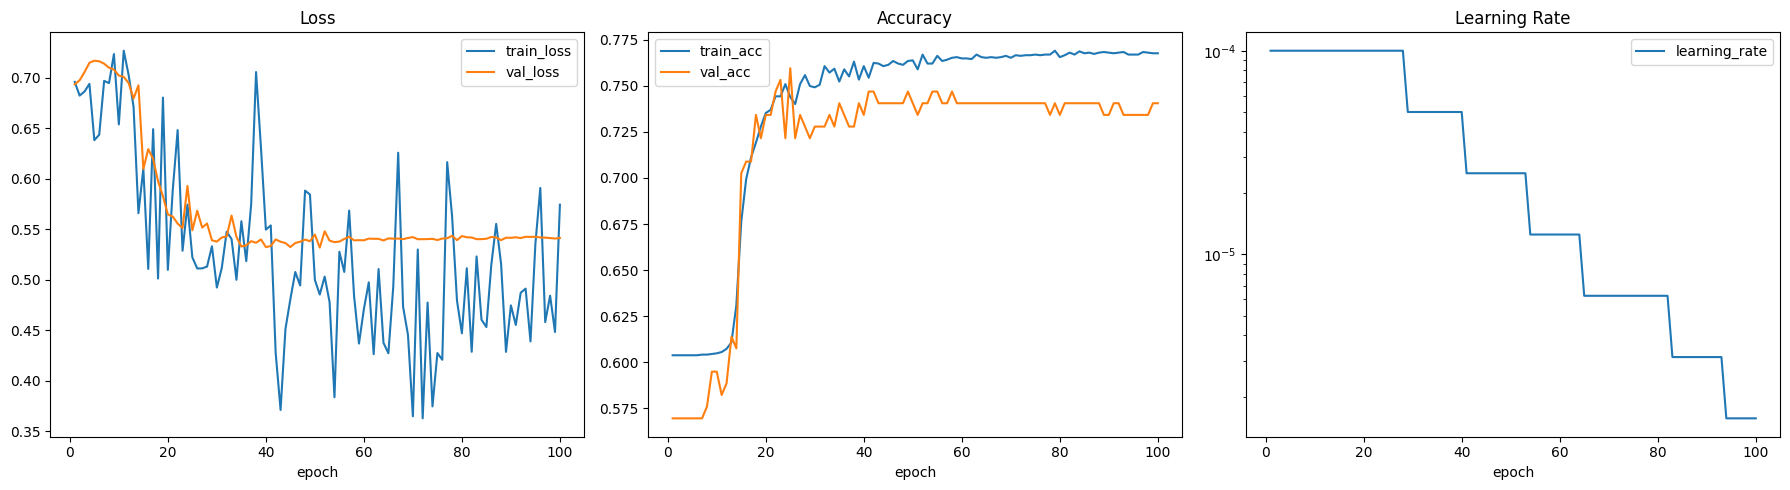

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

baseline_model_name = history['model'] == 'baseline'

history[baseline_model_name].plot(x='epoch', y=['train_loss', 'val_loss'], title='Loss', ax=axes[0])
history[baseline_model_name].plot(x='epoch', y=['train_acc', 'val_acc'], title='Accuracy', ax=axes[1])
history[baseline_model_name].plot(x='epoch', y='learning_rate', title='Learning Rate', ax=axes[2], logy=True)

plt.tight_layout()
plt.show()

# Model 1

In [43]:
model1 = BaselineModel(emb_model_augmented, hidden_dim=128, lstm_layers=2)
model1.word_embeddings.weight.requires_grad = False # freeze the embeddings
model1.to(device)

BaselineModel(
  (word_embeddings): Embedding(1194307, 50, padding_idx=1194306)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [44]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

In [ ]:
history_model1 = train_model(model1, train_dloader, val_dloader, loss_function, optimizer, scheduler, num_epochs=100, name='model1', verbose=True)

Epoch 1/50	Loss: 0.6937	Acc: 0.6038	Val Loss: 0.6972	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 2/50	Loss: 0.6948	Acc: 0.6038	Val Loss: 0.7136	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 3/50	Loss: 0.6028	Acc: 0.6038	Val Loss: 0.7228	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 4/50	Loss: 0.7003	Acc: 0.6038	Val Loss: 0.7197	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 5/50	Loss: 0.7153	Acc: 0.6038	Val Loss: 0.7180	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 6/50	Loss: 0.6803	Acc: 0.6038	Val Loss: 0.7146	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 7/50	Loss: 0.6986	Acc: 0.6038	Val Loss: 0.7138	Val Acc: 0.5696	macro_f1: 0.3629	lr: 0.000100
Epoch 8/50	Loss: 0.6752	Acc: 0.6042	Val Loss: 0.7108	Val Acc: 0.5886	macro_f1: 0.4096	lr: 0.000100
Epoch 9/50	Loss: 0.6526	Acc: 0.6042	Val Loss: 0.7048	Val Acc: 0.5759	macro_f1: 0.4143	lr: 0.000100
Epoch 10/50	Loss: 0.6408	Acc: 0.6052	Val Loss: 0.7030	Val Acc: 0.5886	macro_f1: 0.4419	lr: 0.000100
Epoch 11/

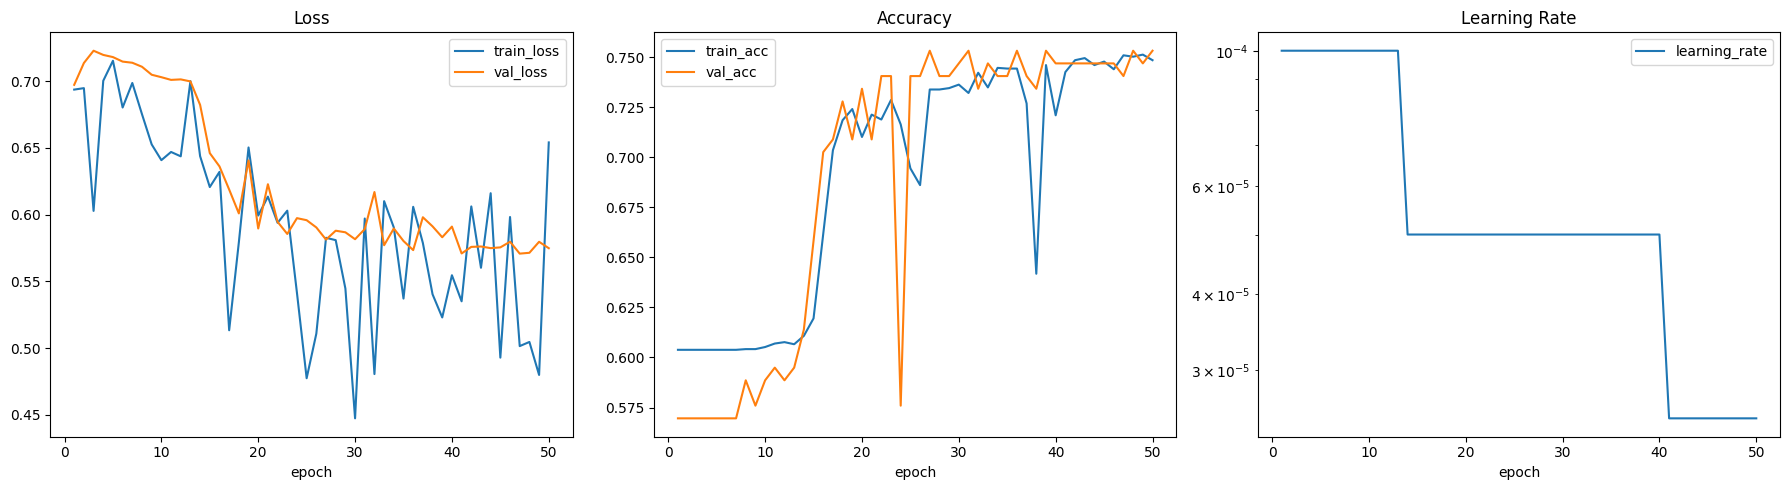

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

baseline_model_name = history['model'] == 'model1'

history[baseline_model_name].plot(x='epoch', y=['train_loss', 'val_loss'], title='Loss', ax=axes[0])
history[baseline_model_name].plot(x='epoch', y=['train_acc', 'val_acc'], title='Accuracy', ax=axes[1])
history[baseline_model_name].plot(x='epoch', y='learning_rate', title='Learning Rate', ax=axes[2], logy=True)

plt.tight_layout()
plt.show()

# Task 6: Transformers

https://huggingface.co/cardiffnlp/twitter-roberta-base-hate

1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [33]:
model_card = 'cardiffnlp/twitter-roberta-base-hate'

tokenizer = AutoTokenizer.from_pretrained(model_card)

In [34]:
train_data = Dataset.from_pandas(train)
val_data = Dataset.from_pandas(val)
test_data = Dataset.from_pandas(test)

In [35]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)

In [36]:
train_data = train_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

In [37]:
print(train_data)
print(test_data)

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_label_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_label_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 286
})


In [38]:
original_text = train_data['tweet'][50]
decoded_text = tokenizer.decode(train_data['input_ids'][50])
print(original_text)
print()
print()
print(decoded_text)

i get it kind of of woman are going after about of men and ignoring the rest according to statistic of dating apps so that s a pain point for some men but is hating woman really a main component to being an incel and what s the difference between mgtow and incel


<s>i get it kind of of woman are going after about of men and ignoring the rest according to statistic of dating apps so that s a pain point for some men but is hating woman really a main component to being an incel and what s the difference between mgtow and incel</s>


In [39]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [40]:
model = AutoModelForSequenceClassification.from_pretrained(model_card,
                                                           num_labels=2,
                                                           id2label={0: 'NEG', 1: 'POS'},
                                                           label2id={'NEG': 0, 'POS': 1})

In [41]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [46]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = (predictions[:, 1] > 0.5)
    
    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [47]:
training_args = TrainingArguments(
    output_dir="models",                 # where to save model
    learning_rate=1e-5,                   
    per_device_train_batch_size=BATCH_SIZE,         # accelerate defines distributed training
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=1,
    weight_decay=1e-5,
    evaluation_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                       # disabling wandb (default)
)

f:\VSCODE\Python\Sexism-detection\.venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

C:\Users\Matte\AppData\Local\Temp\ipykernel_23620\4171576305.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [49]:
trainer.train()

  0%|          | 0/23 [00:00<?, ?it/s]

: 

# Task 7: Error Analysis

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

# Task 8: Report

Wrap up your experiment in a short report (up to 2 pages).

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.